We implement **LeNet** and **ResNet** on **MNIST** and **CIFAR-10** datasets respectively.

In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import argparse
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Hyperparameters
batch_size = 128        
learning_rate = 1e-2    
num_epoches = 20 

## 1. MNIST

In [5]:
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### LeNet 

In [6]:
# Construct Lenet
class Lenet(nn.Module):
    def __init__(self, in_dim, n_class):
        super(Lenet, self).__init__()    
        self.conv = nn.Sequential(    
            nn.Conv2d(in_dim, 6, 5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, stride=1, padding=0),
            nn.ReLU(True), 
            nn.MaxPool2d(2, 2))

        self.fc = nn.Sequential(
            nn.Linear(400, 120), 
            nn.Linear(120, 84), 
            nn.Linear(84, n_class))

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
model = Lenet(1, 10)  


# 定义loss和optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

trainlosslst = []
testlosslst  = []
accuracylst  = [] 

# 开始训练
for epoch in range(num_epoches):
    print('======epoch {}======'.format(epoch + 1))     
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        img = Variable(img)
        label = Variable(label)
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
        running_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        accuracy = (pred == label).float().mean()
        running_acc += num_correct.item()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Finished, Training loss: {:.6f}'.format(
         running_loss / (len(train_dataset))))
    trainlosslst.append(running_loss / (len(train_dataset)))
    model.eval()
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        img, label = data
        img = Variable(img, volatile=True)
        label = Variable(label, volatile=True)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('\nTest loss: {:.6f}, Accuracy: {:.6f}\n'.format(eval_loss / (len(test_dataset)), eval_acc / (len(test_dataset))))
    testlosslst.append(eval_loss / (len(test_dataset)))
    accuracylst.append(eval_acc / (len(test_dataset)))

======epoch 1======
Finished, Training loss: 2.253149

Test loss: 1.988760, Accuracy: 0.541800

======epoch 2======
Finished, Training loss: 0.825822

Test loss: 0.434978, Accuracy: 0.869600

======epoch 3======
Finished, Training loss: 0.378754

Test loss: 0.305834, Accuracy: 0.907600

======epoch 4======
Finished, Training loss: 0.290514

Test loss: 0.240826, Accuracy: 0.928700

======epoch 5======
Finished, Training loss: 0.236476

Test loss: 0.201924, Accuracy: 0.937600

======epoch 6======
Finished, Training loss: 0.199857

Test loss: 0.169406, Accuracy: 0.948700

======epoch 7======
Finished, Training loss: 0.171442

Test loss: 0.151506, Accuracy: 0.954500

======epoch 8======
Finished, Training loss: 0.151820

Test loss: 0.134077, Accuracy: 0.959600

======epoch 9======
Finished, Training loss: 0.136174

Test loss: 0.121623, Accuracy: 0.963300

======epoch 10======
Finished, Training loss: 0.124017

Test loss: 0.117150, Accuracy: 0.965300

======epoch 11======
Finished, Training

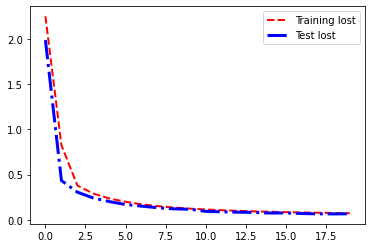

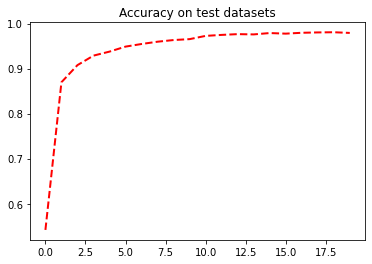

In [8]:
plt.plot(range(num_epoches),trainlosslst,color='red',linewidth=2.0,linestyle='--',label="Training lost")
plt.plot(range(num_epoches),testlosslst,color='blue',linewidth=3.0,linestyle='-.',label="Test lost")
plt.legend()
plt.show()

plt.plot(range(num_epoches),accuracylst,color='red',linewidth=2.0,linestyle='--',label="Accuracy")
plt.title("Accuracy on test datasets")
plt.show()

### ResNet 

In [9]:

class ResidualBlock(nn.Module):

    def __init__(self, channel):
        super().__init__()
        self.conv1 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)

    def forward(self, x):

        y = F.relu(self.conv1(x))
        y = self.conv2(y)

        return F.relu(x + y)


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.res_block_1 = ResidualBlock(16)
        self.res_block_2 = ResidualBlock(32)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = self.res_block_1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.res_block_2(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)



In [ ]:
model = ResNet()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

trainlosslst = []
testlosslst  = []
accuracylst  = []

def train(epoch):
    print('======epoch {}======'.format(epoch))      
    model.train()
    correct = 0 
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    print('Finished. Training loss: {:.6f}'.format(loss.item()))
    trainlosslst.append(loss.item())

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format(
        test_loss, correct / len(test_loader.dataset)
    ))
    testlosslst.append(test_loss)
    accuracylst.append(correct / len(test_loader.dataset))

for epoch in range(1, num_epoches + 1):
    train(epoch)
    test()

======epoch 1======


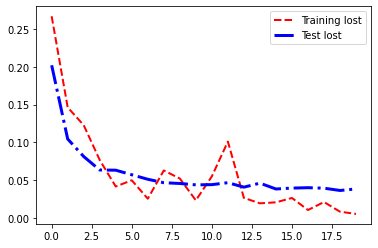

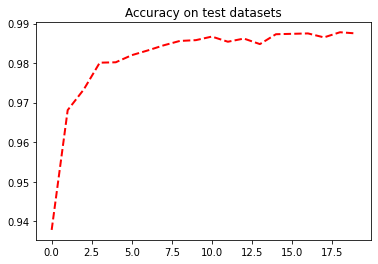

In [9]:
plt.plot(range(num_epoches),trainlosslst,color='red',linewidth=2.0,linestyle='--',label="Training lost")
plt.plot(range(num_epoches),testlosslst,color='blue',linewidth=3.0,linestyle='-.',label="Test lost")
plt.legend()
plt.show()

plt.plot(range(num_epoches),accuracylst,color='red',linewidth=2.0,linestyle='--',label="Accuracy")
plt.title("Accuracy on test datasets")
plt.show()

## 2. CIFAR-10

In [30]:
train_dataset = datasets.CIFAR10(root='./data/', train=True,transform=transforms.Compose(( 
                                transforms.Resize(32,32),
                                transforms.ToTensor()))) 

train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)

test_dataset = datasets.CIFAR10(root='./data/', train=False,transform=transforms.Compose((  
                                transforms.Resize(32,32),
                                transforms.ToTensor()))) 

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [11]:
# Construct network
class lenet5(nn.Module):
    def __init__(self):
        super(lenet5,self).__init__()
        
        self.conv_unit = nn.Sequential(     
        nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0),
        nn.AvgPool2d(kernel_size=2,stride=2,padding=0),            
        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0),
        nn.AvgPool2d(kernel_size=2,stride=2,padding=0)
        )
        
        self.fc_unit = nn.Sequential(
        nn.Linear(16*5*5,120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
        )        
        
    def forward(self,x):
        batch_size = x.shape[0]
        x = self.conv_unit(x)
        x = x.reshape(batch_size,16*5*5)
        logits = self.fc_unit(x)
        return logits

In [12]:

model = lenet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

trainlosslst = []
testlosslst  = []
accuracylst  = []

# 开始训练
for epoch in range(num_epoches):
    print('======epoch {}======'.format(epoch + 1))     
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        img = Variable(img)
        label = Variable(label)
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
        running_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        accuracy = (pred == label).float().mean()
        running_acc += num_correct.item()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Finished, Training loss: {:.6f}'.format(
         running_loss / (len(train_dataset))))
    trainlosslst.append(running_loss / (len(train_dataset)))
    
# Test    
    model.eval()
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        img, label = data
        img = Variable(img, volatile=True)
        label = Variable(label, volatile=True)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('\nTest loss: {:.6f}, Accuracy: {:.6f}\n'.format(eval_loss / (len(test_dataset)), eval_acc / (len(test_dataset))))
    testlosslst.append(eval_loss / (len(test_dataset)))
    accuracylst.append(eval_acc / (len(test_dataset)))

======epoch 1======
Finished, Training loss: 2.211536

Test loss: 2.037462, Accuracy: 0.255900

======epoch 2======
Finished, Training loss: 1.926440

Test loss: 1.827766, Accuracy: 0.338000

======epoch 3======
Finished, Training loss: 1.740408

Test loss: 1.652130, Accuracy: 0.407500

======epoch 4======
Finished, Training loss: 1.619585

Test loss: 1.556682, Accuracy: 0.444700

======epoch 5======
Finished, Training loss: 1.546354

Test loss: 1.508378, Accuracy: 0.462000

======epoch 6======
Finished, Training loss: 1.491378

Test loss: 1.483267, Accuracy: 0.463300

======epoch 7======
Finished, Training loss: 1.446138

Test loss: 1.468053, Accuracy: 0.472500

======epoch 8======
Finished, Training loss: 1.408133

Test loss: 1.409063, Accuracy: 0.497900

======epoch 9======
Finished, Training loss: 1.374840

Test loss: 1.415148, Accuracy: 0.501700

======epoch 10======
Finished, Training loss: 1.344163

Test loss: 1.399302, Accuracy: 0.500100

======epoch 11======
Finished, Training

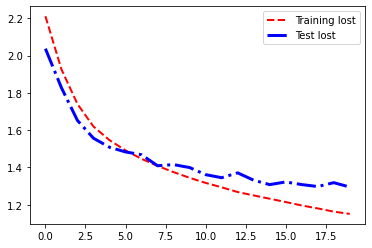

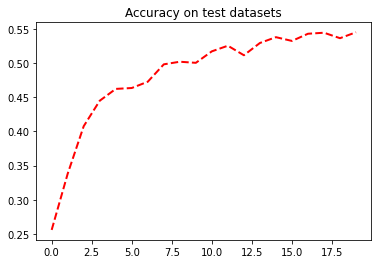

In [13]:
plt.plot(range(num_epoches),trainlosslst,color='red',linewidth=2.0,linestyle='--',label="Training lost")
plt.plot(range(num_epoches),testlosslst,color='blue',linewidth=3.0,linestyle='-.',label="Test lost")
plt.legend()
plt.show()

plt.plot(range(num_epoches),accuracylst,color='red',linewidth=2.0,linestyle='--',label="Accuracy")
plt.title("Accuracy on test datasets")
plt.show()

### Rsenet

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)

In [40]:
net = ResNet18()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) 


for epoch in range(1):
    print('======epoch {}======'.format(epoch + 1)) 
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(train_loader, 0):
        length = len(train_loader)
        inputs, labels = data
        inputs, labels = inputs, labels
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每训练1个batch打印一次loss和准确率
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        if i%10 ==0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                  % (epoch + 1, (i + epoch * length), sum_loss / (i + 1), 100. * correct / total))

    # Test
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            net.eval()
            images, labels = data
            images, labels = images, labels
            outputs = net(images)
            # 取得分最高的那个类 (outputs.data的索引号)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Accuracy on the test dataset：%.3f%%' % (100 * correct / total))

======epoch 1======
[epoch:1, iter:0] Loss: 2.397 | Acc: 10.938% 
[epoch:1, iter:10] Loss: 2.171 | Acc: 19.034% 
[epoch:1, iter:20] Loss: 2.045 | Acc: 24.033% 
[epoch:1, iter:30] Loss: 1.954 | Acc: 28.049% 
[epoch:1, iter:40] Loss: 1.891 | Acc: 30.335% 
[epoch:1, iter:50] Loss: 1.838 | Acc: 32.521% 
[epoch:1, iter:60] Loss: 1.794 | Acc: 33.696% 
[epoch:1, iter:70] Loss: 1.759 | Acc: 35.079% 
[epoch:1, iter:80] Loss: 1.734 | Acc: 36.073% 
[epoch:1, iter:90] Loss: 1.710 | Acc: 36.779% 
[epoch:1, iter:100] Loss: 1.684 | Acc: 37.833% 
[epoch:1, iter:110] Loss: 1.659 | Acc: 38.802% 
[epoch:1, iter:120] Loss: 1.648 | Acc: 39.237% 
[epoch:1, iter:130] Loss: 1.634 | Acc: 39.772% 
[epoch:1, iter:140] Loss: 1.617 | Acc: 40.448% 
[epoch:1, iter:150] Loss: 1.604 | Acc: 40.941% 
[epoch:1, iter:160] Loss: 1.588 | Acc: 41.576% 
[epoch:1, iter:170] Loss: 1.571 | Acc: 42.261% 
[epoch:1, iter:180] Loss: 1.551 | Acc: 43.077% 
[epoch:1, iter:190] Loss: 1.536 | Acc: 43.648% 
[epoch:1, iter:200] Loss: 1.523

注：Resnet在CIFAR-10数据集上跑的非常慢，故只输出了一个epoch.